In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8243073464674267987, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11284480000
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17186124109951208974
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [3]:
from utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

In [4]:
random_state = 42

In [5]:
ids_train_ = load_array("data/array/ids_train")
X_train_ = load_array("data/array/X_train")
y_train_ = load_array("data/array/y_train").astype(np.bool)
strata_train = load_array("data/array/strata_train")
# ids_test = load_array("data/array/ids_test")
# X_test = load_array("data/array/X_test")

In [6]:
im_width = X_train_.shape[1]
im_height = X_train_.shape[2]
im_chan = X_train_.shape[3]

In [7]:
X_train_.shape, y_train_.shape, im_width, im_height, im_chan

((4000, 128, 128, 1), (4000, 128, 128, 1), 128, 128, 1)

## Data Augmentation

We flip the images along the y axis

In [8]:
X_train_ = np.append(X_train_, [np.fliplr(x) for x in X_train_], axis=0)
y_train_ = np.append(y_train_, [np.fliplr(x) for x in y_train_], axis=0)

In [9]:
strata_train = np.append(strata_train, strata_train)

In [10]:
X_train_.shape, y_train_.shape, strata_train.shape

((8000, 128, 128, 1), (8000, 128, 128, 1), (8000,))

## Train/valid slip

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_,
    y_train_,
    test_size=0.2, stratify=strata_train, random_state=random_state)

In [12]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6400, 128, 128, 1),
 (1600, 128, 128, 1),
 (6400, 128, 128, 1),
 (1600, 128, 128, 1))

## Model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [14]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
input_layer = Input((im_height, im_width, im_chan))
# input_layer = Lambda(lambda x: x / 255) (input_layer)

In [16]:
output_layer = build_model(input_layer, 16)

In [17]:
model = Model(input_layer, output_layer)

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy', mean_iou])

In [19]:
# model.summary()

In [20]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./models/unet-dropout.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

In [21]:
history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 1600 samples
Epoch 1/200
6400/6400 [==============================] - 52s 8ms/step - loss: 0.7242 - acc: 0.7389 - mean_iou: 0.3799 - val_loss: 0.4098 - val_acc: 0.7561 - val_mean_iou: 0.3814

Epoch 00001: val_loss improved from inf to 0.40980, saving model to ./models/unet_dropout.model
Epoch 2/200
6400/6400 [==============================] - 47s 7ms/step - loss: 0.4085 - acc: 0.8123 - mean_iou: 0.3839 - val_loss: 0.3684 - val_acc: 0.8586 - val_mean_iou: 0.3898

Epoch 00002: val_loss improved from 0.40980 to 0.36838, saving model to ./models/unet_dropout.model
Epoch 3/200
6400/6400 [==============================] - 47s 7ms/step - loss: 0.3512 - acc: 0.8670 - mean_iou: 0.4125 - val_loss: 0.4647 - val_acc: 0.8069 - val_mean_iou: 0.4441

Epoch 00003: val_loss did not improve from 0.36838
Epoch 4/200
6400/6400 [==============================] - 47s 7ms/step - loss: 0.3461 - acc: 0.8679 - mean_iou: 0.4660 - val_loss: 0.4095 - val_acc: 0.8430 - val_mean_io

## Check the predictions

Let's check one prediction

In [22]:
pred_train = model.predict(X_train, verbose=1)

6400/6400 [==============================] - 11s 2ms/step


In [23]:
pred_train.shape

(6400, 128, 128, 1)

In [24]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as image_utils

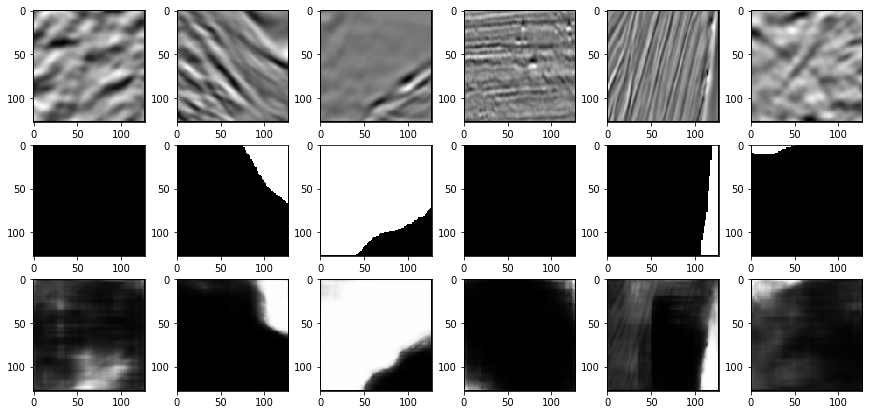

In [27]:
n_images = 6
fig, axarr = plt.subplots(3, n_images, figsize=(15, 7))
for image in range(n_images):
    n = random.randint(1, pred_train.shape[0])
    axarr[0, image].imshow(image_utils.array_to_img(X_train[n]))
    axarr[1, image].imshow(image_utils.array_to_img(y_train[n]))
    axarr[2, image].imshow(image_utils.array_to_img(pred_train[n]))